<a href="https://colab.research.google.com/github/Shahzad-Ansari/DSA-CAPSTONE/blob/main/ML_Binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score
from sklearn.tree import export_text
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from imblearn.metrics import specificity_score
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit



In [2]:
location = pd.read_pickle('/content/drive/MyDrive/Colab_Notebooks/Capstone_Dataframes/surveyData_with_Counties_and_FIPS.pickle')
location = location.drop(columns = ['FIPS','county_lat','county_long'])

# General Functions

## Class Imbalance

In [3]:
import pandas as pd

def check_imbalance(df, threshold=0.2):
    imbalance_data = []

    for col in df.columns:
        col_counts = df[col].value_counts()
        col_percentages = col_counts / col_counts.sum()
        minority_percentage = col_percentages.min()
        is_unbalanced = 'Yes' if minority_percentage < threshold else 'No'

        imbalance_data.append({
            'Column Name': col,
            'Minority Class': col_percentages.idxmin(),
            'Minority Percentage': minority_percentage * 100,
            'Is Unbalanced': is_unbalanced
        })

    imbalance_df = pd.DataFrame(imbalance_data)
    return imbalance_df

## Plot Confusion Matrix

In [4]:

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm,classes,Title):
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)

    # Set plot labels and title
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'{Title} Confusion Matrix')
    
    plt.show()


## Plot AUC

In [5]:
def displayAUC(y_test_binarized_best, y_score_best, class_names, title):
    n_classes = y_test_binarized_best.shape[1]
    
    if n_classes == 1: # binary classification
        fpr, tpr, _ = roc_curve(y_test_binarized_best, y_score_best)
        roc_auc = auc(fpr, tpr)
        fig = go.Figure(go.Scatter(x=fpr, y=tpr))
        fig.update_layout(
            title=f"{title} (AUC-ROC = {roc_auc:.6f})",
            xaxis_title="False Positive Rate",
            yaxis_title="True Positive Rate",
        )
    else: # multi-class classification
        # Compute ROC curve and AUC for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_binarized_best[:, i], y_score_best[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Calculate the weighted average ROC AUC score
        auc_roc = roc_auc_score(y_test_binarized_best, y_score_best, multi_class='ovr', average='weighted')

        # Create a Plotly graph for the ROC curve
        fig = go.Figure()

        for i in range(n_classes):
            fig.add_trace(
                go.Scatter(
                    x=fpr[i],
                    y=tpr[i],
                    mode="lines",
                    name=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})"
                )
            )

        # Add diagonal line representing a random classifier
        fig.add_shape(
            type="line",
            x0=0, x1=1,
            y0=0, y1=1,
            yref="y", xref="x",
            line=dict(color="rgba(0, 0, 0, 0.3)", dash="dash")
        )

        fig.update_layout(
            title=f"{title} (Weighted AUC-ROC = {auc_roc:.6f})",
            xaxis_title="False Positive Rate",
            yaxis_title="True Positive Rate",
            legend_title="Class",
            legend=dict(
                yanchor="top",
                y=0.99,
                xanchor="left",
                x=0.01
            )
        )

    return fig


## Descision Tree

In [6]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score

def compute_average_metrics_and_importances_dt(classifier, X, y, n_iterations=10, save_model=True, model_filename='Decision_Tree.pkl',displayOutput=True):
    feature_importances = np.zeros(X.shape[1])
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    auc_roc_scores = []
    best_auc_roc = -1
    best_model = None
    best_scores = None
    y_test_binarized_best = None
    y_score_best= None
    specificity_scores = []
    balanced_accuracy_scores = []
    best_balanced_accuracy = -1
    

    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3)
    
    for i in range(n_iterations):
        for train_index, test_index in cv.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
        
            # Train a decision tree classifier
            classifier.fit(X_train, y_train)
            # Add feature importances from the current iteration
            feature_importances += classifier.feature_importances_

            # Test the classifier on the test set and store the metrics
            y_pred = classifier.predict(X_test)
            y_score = classifier.predict_proba(X_test)[:, 1] # only for binary classification
            y_test_binarized = label_binarize(y_test, classes=np.unique(y))
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            auc_roc = roc_auc_score(y_test, y_score)
            specificity = specificity_score(y_test,y_pred,average='weighted')
            balanced_accuracy = (recall + specificity) / 2

            if auc_roc > best_auc_roc:
              best_auc_roc = auc_roc
              best_model = classifier
              best_scores = (accuracy, precision, recall, f1, auc_roc)
              y_test_binarized_best = y_test_binarized
              y_score_best= y_score

            cm = confusion_matrix(y_test, y_pred)

            accuracy_scores.append(accuracy)
            precision_scores.append(precision)
            recall_scores.append(recall)
            f1_scores.append(f1)
            auc_roc_scores.append(auc_roc)
            specificity_scores.append(specificity)
            balanced_accuracy_scores.append(balanced_accuracy)

            if displayOutput == True:
              print(f"Iteration {i + 1}:")
              print(f"  Accuracy: {accuracy:.2f}")
              print(f"  Precision: {precision:.2f}")
              print(f"  Recall: {recall:.2f}")
              print(f"  F1 score: {f1:.2f}")
              print(f"  AUC-ROC score: {auc_roc:.2f}")
              print(f"  Specificity score: {specificity:.2f}")
              print(f"  Balanced Accuracy Score: {balanced_accuracy:.2f}")

    with open(model_filename, 'wb') as f:
      pickle.dump(best_model, f)
    # Compute the average metrics and feature importances
    average_importances = feature_importances / n_iterations
    average_accuracy = np.mean(accuracy_scores)
    average_precision = np.mean(precision_scores)
    average_recall = np.mean(recall_scores)
    average_f1 = np.mean(f1_scores)
    average_auc_roc = np.mean(auc_roc_scores)
    average_specificity = np.mean(specificity_scores)
    average_balance = np.mean(balanced_accuracy_scores)

    return cm,(average_accuracy, average_precision, average_recall, average_f1, average_auc_roc,average_specificity,average_balance), best_scores, best_model, y_test_binarized_best, y_score_best


## Random Forest

In [7]:
def compute_average_metrics_and_importances_rf(classifier, X, y, n_iterations=10, save_model=True, model_filename='Random_Forest.pkl', displayOutput=True):
    feature_importances = np.zeros(X.shape[1])
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    auc_roc_scores = []
    specificity_scores = []
    balanced_accuracy_scores = []
    best_auc_roc = -1
    best_balanced_accuracy = -1
    best_model = None
    best_scores = None
    y_test_binarized_best = None
    y_score_best = None

    tqdm.pandas(desc = 'Iterations')
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3)
    for i in tqdm(range(n_iterations)):
        for train_index, test_index in cv.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # Train a Random Forest classifier
            classifier.fit(X_train, y_train)

            # Add feature importances from the current iteration
            feature_importances += classifier.feature_importances_

            # Test the classifier on the test set and store the metrics
            y_pred = classifier.predict(X_test)
            y_score = classifier.predict_proba(X_test)[:,1]
            y_test_binarized = label_binarize(y_test, classes=[0, 1])
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='binary', zero_division=0)
            recall = recall_score(y_test, y_pred, average='binary', zero_division=0)
            f1 = f1_score(y_test, y_pred, average='binary')        
            specificity = specificity_score(y_test,y_pred,average='binary')
            balanced_accuracy = (recall + specificity) / 2

            try:
                auc_roc = roc_auc_score(y_test_binarized, y_score, average='weighted')
            except ValueError:
                print(f"Iteration {i + 1}: Skipped due to only one class present in y_true.")
                continue

            if balanced_accuracy > best_balanced_accuracy:
                best_balanced_accuracy = balanced_accuracy
                best_auc_roc = auc_roc
                best_model = classifier
                best_scores = (accuracy, precision, recall, f1, auc_roc, specificity, balanced_accuracy)
                y_test_binarized_best = y_test_binarized
                y_score_best = y_score

            cm = confusion_matrix(y_test, y_pred)

            accuracy_scores.append(accuracy)
            precision_scores.append(precision)
            recall_scores.append(recall)
            f1_scores.append(f1)
            auc_roc_scores.append(auc_roc)
            specificity_scores.append(specificity)
            balanced_accuracy_scores.append(balanced_accuracy)

            if displayOutput == True:
                print(f"Iteration {i + 1}:")
                print(f"  Accuracy: {accuracy:.2f}")
                print(f"  Precision: {precision:.2f}")
                print(f"  Recall: {recall:.2f}")
                print(f"  F1 score: {f1:.2f}")
                print(f"  AUC-ROC score: {auc_roc:.2f}")
                print(f"  Specificity score: {specificity:.2f}")
                print(f"  Balanced Accuracy Score: {balanced_accuracy:.2f}")

    with open('/content/drive/MyDrive/Colab_Notebooks/Capstone_Dataframes/randomForest.pkl', 'wb') as f:
      pickle.dump(best_model, f)

    # Compute the average metrics and feature importances
    average_importances = feature_importances / n_iterations
    average_accuracy = np.mean(accuracy_scores)
    average_precision = np.mean(precision_scores)
    average_recall = np.mean(recall_scores)
    average_f1 = np.mean(f1_scores)
    average_auc_roc = np.mean(auc_roc_scores)
    average_specificity = np.mean(specificity_scores)
    average_balance = np.mean(balanced_accuracy_scores)

    return cm,average_importances, (average_accuracy, average_precision, average_recall,  average_f1, average_auc_roc, average_specificity,average_balance), best_scores,best_model,y_test_binarized_best,y_score_best



## KNN

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, confusion_matrix
from sklearn.preprocessing import label_binarize
import numpy as np
import pickle

def compute_average_metrics_KNN_binary(classifier, X, y, n_iterations=10, save_model=True, model_filename='KNN.pkl', displayOutput=True):
  accuracy_scores = []
  precision_scores = []
  recall_scores = []
  f1_scores = []
  auc_roc_scores = []
  specificity_scores = []
  balanced_accuracy_scores = []
  best_auc_roc = -1
  best_model = None
  best_scores = None
  y_test_binarized_best = None
  y_score_best= None
  best_balanced_accuracy = -1
  cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3)

  for i in range(n_iterations):
    for train_index, test_index in cv.split(X, y):
          X_train, X_test = X[train_index], X[test_index]
          y_train, y_test = y[train_index], y[test_index]
      
          # Train a KNN classifier
          classifier.fit(X_train, y_train)

          # Test the classifier on the test set and store the metrics
          y_pred = classifier.predict(X_test)
          y_score = classifier.predict_proba(X_test)[:,1]
          y_test_binarized = label_binarize(y_test, classes=[0,1])
          accuracy = accuracy_score(y_test, y_pred)
          precision = precision_score(y_test, y_pred, average='binary', zero_division=0)
          recall = recall_score(y_test, y_pred, average='binary', zero_division=0)
          f1 = f1_score(y_test, y_pred, average='binary')
          try:
              auc_roc = roc_auc_score(y_test_binarized, y_score, average='weighted')
          except ValueError:
              print(f"Iteration {i + 1}: Skipped due to only one class present in y_true.")
              continue
          specificity = specificity_score(y_test,y_pred)
          balanced_accuracy = (recall + specificity) / 2

          if balanced_accuracy > best_balanced_accuracy:
            best_balanced_accuracy = balanced_accuracy
            best_auc_roc = auc_roc
          best_model = classifier
          best_scores = (accuracy, precision, recall, f1, auc_roc,specificity,balanced_accuracy)
          y_test_binarized_best = y_test_binarized
          y_score_best= y_score

          accuracy_scores.append(accuracy)
          precision_scores.append(precision)
          recall_scores.append(recall)
          f1_scores.append(f1)
          auc_roc_scores.append(auc_roc)
          specificity_scores.append(specificity)
          balanced_accuracy_scores.append(balanced_accuracy)

          cm = confusion_matrix(y_test, y_pred)


          if displayOutput == True:
              print(f"Iteration {i + 1}:")
              print(f"  Accuracy: {accuracy:.2f}")
              print(f"  Precision: {precision:.2f}")
              print(f"  Recall: {recall:.2f}")
              print(f"  F1 score: {f1:.2f}")
              print(f"  AUC-ROC score: {auc_roc:.2f}")
              print(f"  Specificity score: {specificity:.2f}")
              print(f"  Balanced Accuracy Score: {balanced_accuracy:.2f}")

  with open(model_filename, 'wb') as f:
      pickle.dump(best_model, f)

  average_accuracy = np.mean(accuracy_scores)
  average_precision = np.mean(precision_scores)
  average_recall = np.mean(recall_scores)
  average_f1 = np.mean(f1_scores)
  average_auc_roc = np.mean(auc_roc_scores)
  average_specificity = np.mean(specificity_scores)
  average_balance = np.mean(balanced_accuracy_scores)

  avg_scores = (average_accuracy, average_precision, average_recall, average_f1, average_auc_roc, average_specificity, average_balance)

  return cm, avg_scores, best_scores, best_model, y_test_binarized_best, y_score_best



# Global Warming Belief

## Target and Training data

In [ ]:
target = 'glbcc'
data, holdout = train_test_split(location, test_size=0.2, stratify=location[target])
data = data.reset_index()
# Load the data into a pandas dataframe
# Split the dataframe into X (features) and y (target variable)
X = data.drop(target, axis=1)
y = data[target]
class_names  = ['Yes','No']

## Feature Selection

<ipython-input-69-4209cb4f7000>:15: UserWarning:

FixedFormatter should only be used together with FixedLocator



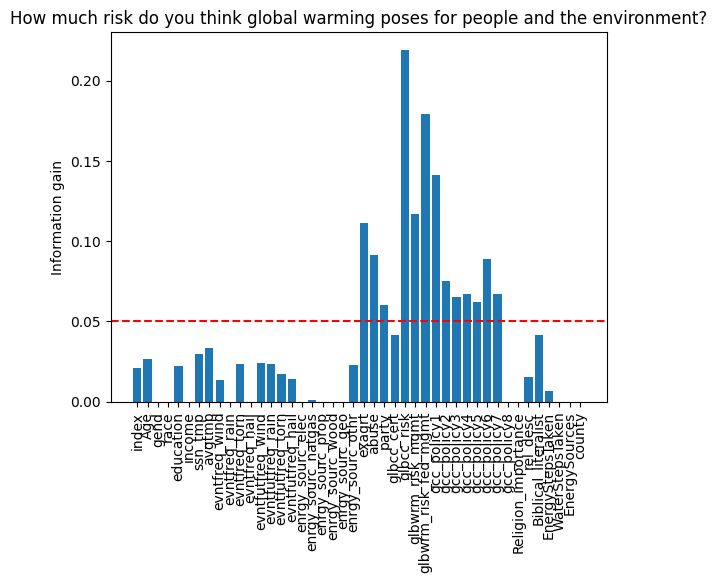

Selected columns: ['exagrt', 'abuse', 'party', 'glbcc_risk', 'glbwrm_risk_mgmt', 'glbwrm_risk_fed_mgmt', 'gcc_policy1', 'gcc_policy2', 'gcc_policy3', 'gcc_policy4', 'gcc_policy5', 'gcc_policy6', 'gcc_policy7']


In [ ]:
import pandas as pd
from sklearn.feature_selection import mutual_info_classif

# Encode categorical variables into integers
encoder = OrdinalEncoder()
X_encoded = encoder.fit_transform(X)

threshold = .05
# Calculate the information gain for each feature
info_gain = mutual_info_classif(X_encoded, y)

fig, ax = plt.subplots()
ax.bar(X.columns, info_gain)
ax.axhline(y=threshold, color='r', linestyle='--') # redline at threshold
ax.set_xticklabels(X.columns, rotation=90)
ax.set_ylabel('Information gain')
ax.set_title('How much risk do you think global warming poses for people and the environment?')
plt.show()

# Select the columns that have information gain scores above 0.1
selected_cols = X.columns[info_gain > threshold].tolist()
print(f'Selected columns: {selected_cols}')

## Checking Class imbalences

In [ ]:
df = data[selected_cols]
# Usage example
threshold = 0.2  # Set the imbalance threshold
imbalance_df = check_imbalance(df, threshold)
print(imbalance_df)

             Column Name  Minority Class  Minority Percentage Is Unbalanced
0                 exagrt             0.0             0.441501           Yes
1                  abuse             0.0             0.331126           Yes
2                  party             5.0             1.324503           Yes
3             glbcc_risk             2.0             2.428256           Yes
4       glbwrm_risk_mgmt             1.0             0.220751           Yes
5   glbwrm_risk_fed_mgmt             1.0             2.538631           Yes
6            gcc_policy1             0.0             1.434879           Yes
7            gcc_policy2             0.0             0.772627           Yes
8            gcc_policy3             0.0             1.324503           Yes
9            gcc_policy4             0.0             0.883002           Yes
10           gcc_policy5             0.0             1.214128           Yes
11           gcc_policy6             0.0             1.766004           Yes
12          

## Train test split

---



In [ ]:
# Prepare dataset for training
#X = data[selected_cols]
X = data[selected_cols]
X_encoded = encoder.fit_transform(X)
#X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=25)

## Decision Tree

### Model

In [ ]:
# Example usage:
from imblearn.metrics import specificity_score
dt_classifier = DecisionTreeClassifier(criterion='entropy', max_depth=6, max_features='sqrt')
cm,(average_accuracy, average_precision, average_recall, average_f1, average_auc_roc,average_specificity,average_balance), (best_accuracy, best_precision, best_recall, best_f1, best_auc_roc), best_model, y_test_binarized_best, y_score_best = compute_average_metrics_and_importances_dt(dt_classifier, X_encoded, y, n_iterations=1,displayOutput=True)

DecisionTree = export_text(best_model, feature_names=list(X.columns), decimals=2)
#print(DecisionTree)

# Create a DataFrame to display the average feature importances
#average_feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': average_importances})
#topFeatures = average_feature_importances['Feature'].head(10)
# Sort the DataFrame by importance
#average_feature_importances = average_feature_importances.sort_values(by='Importance', ascending=False)
#print(average_feature_importances)
Scores = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 score', 'AUC-ROC','Specificity','Balanced Accuracy'],
    'Average': [average_accuracy, average_precision, average_recall, average_f1, average_auc_roc,average_specificity,average_balance],
    'Best': [best_accuracy, best_precision, best_recall, best_f1, best_auc_roc,best_specificity,best_balance],
}
bestVisualization = displayAUC(y_test_binarized_best,y_score_best,class_names,title = 'Best model')




Iteration 1:
  Accuracy: 0.77
  Precision: 0.81
  Recall: 0.82
  F1 score: 0.81
  AUC-ROC score: 0.80
  Specificity score: 0.74
  Balanced Accuracy Score: 0.78
Iteration 1:
  Accuracy: 0.76
  Precision: 0.81
  Recall: 0.80
  F1 score: 0.81
  AUC-ROC score: 0.83
  Specificity score: 0.74
  Balanced Accuracy Score: 0.77
Iteration 1:
  Accuracy: 0.74
  Precision: 0.76
  Recall: 0.85
  F1 score: 0.80
  AUC-ROC score: 0.77
  Specificity score: 0.68
  Balanced Accuracy Score: 0.76
Iteration 1:
  Accuracy: 0.78
  Precision: 0.86
  Recall: 0.76
  F1 score: 0.81
  AUC-ROC score: 0.86
  Specificity score: 0.79
  Balanced Accuracy Score: 0.77
Iteration 1:
  Accuracy: 0.76
  Precision: 0.83
  Recall: 0.77
  F1 score: 0.80
  AUC-ROC score: 0.80
  Specificity score: 0.75
  Balanced Accuracy Score: 0.76


### Holdout validation

In [ ]:
holdout_test = holdout[target]
holdout1 = holdout.drop(target, axis=1)
holdout1 = holdout1[selected_cols]
holdout1 = encoder.fit_transform(holdout1)



y_pred = best_model.predict(holdout1)
y_score = best_model.predict_proba(holdout1)[:, 1] # only for binary classification
y_test_binarized = label_binarize(holdout_test, classes=np.unique(y))
accuracy = accuracy_score(holdout_test, y_pred)
precision = precision_score(holdout_test, y_pred)
recall = recall_score(holdout_test, y_pred)
f1 = f1_score(holdout_test, y_pred)
auc_roc = roc_auc_score(holdout_test, y_score)
specificity = specificity_score(holdout_test,y_pred,average='weighted')
balanced_accuracy = (recall + specificity) / 2
Scores['Holdout'] = [accuracy, precision, recall, f1, auc_roc,specificity,balanced_accuracy]


holdout_visualization = displayAUC(y_test_binarized,y_score,class_names,title = 'Holdout')

cm2 = confusion_matrix(holdout_test, y_pred)


### Display All output

In [ ]:
scoresDF = pd.DataFrame(Scores)
scoresDF.set_index('Metric', inplace=True)
scoresDF['Difference'] = scoresDF['Best'] - scoresDF['Holdout']
scoresDF['Sign'] = scoresDF['Difference'].apply(lambda x: '+' if x >= 0 else '-')
display(scoresDF)

,Average,Best,Holdout,Difference,Sign
Metric,,,,,
Accuracy,0.762500,0.775735,0.806167,-0.030432,-
Precision,0.815863,0.863946,0.858209,0.005737,+
Recall,0.798810,0.755952,0.821429,-0.065476,-
F1 score,0.806010,0.806349,0.839416,-0.033067,-
AUC-ROC,0.812328,0.858316,0.821675,0.036641,+
Specificity,0.740156,0.807692,0.796870,0.010822,+
Balanced Accuracy,0.769483,0.841346,0.809149,0.032197,+


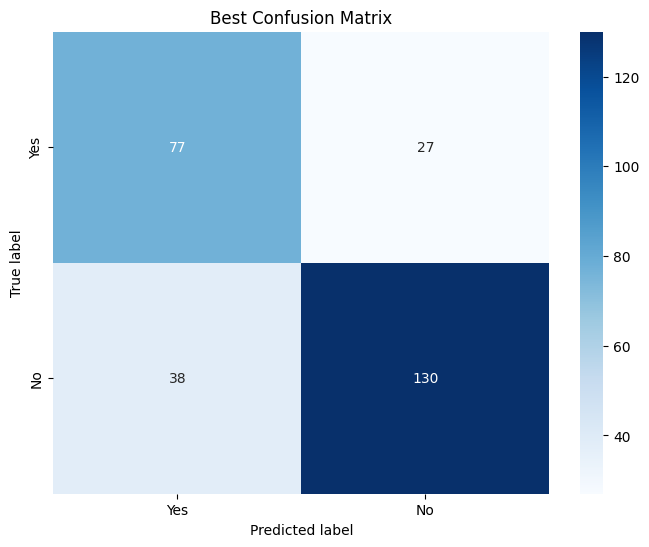

In [ ]:
plot_confusion_matrix(cm,class_names,'Best')
bestVisualization.show()

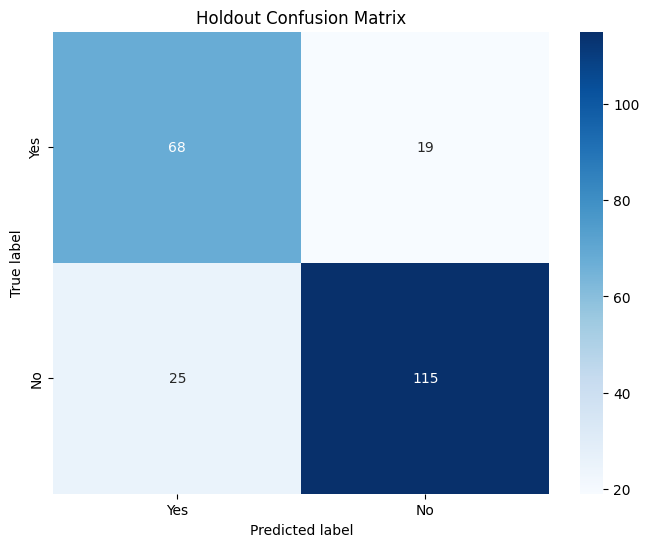

In [ ]:
plot_confusion_matrix(cm2,class_names,'Holdout')
holdout_visualization.show()

## Random Forest

### Grid Search

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3)
# Create the base RandomForestClassifier
base_classifier = RandomForestClassifier(criterion='entropy', max_depth=6, max_features='sqrt',
                                  bootstrap=True, class_weight='balanced', min_samples_leaf=10)

# Define the hyperparameters and their possible values for the grid search
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 6, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Create the GridSearchCV object
from sklearn.model_selection import StratifiedShuffleSplit

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=50)
grid_search = GridSearchCV(estimator=base_classifier, param_grid=param_grid, cv=cv, scoring='f1', n_jobs=-1)

# Assuming X_train and y_train are your training data and labels
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding F1-score
print("Best parameters: ", grid_search.best_params_)
print("Best Balanced Accuracy: ", grid_search.best_score_)

# Retrieve the best model
best_classifier = grid_search.best_estimator_


Best parameters:  {'max_depth': 6, 'max_features': 'auto', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 10}
Best Balanced Accuracy:  0.8541060138125601


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.



### Model

In [ ]:
# Example usage:
# Prepare dataset for training

rf_classifier = RandomForestClassifier(criterion='entropy', max_depth=None, max_features='sqrt', min_samples_leaf=5,n_estimators=100,min_samples_split=2)
cm,average_importances, (average_accuracy, average_precision, average_recall, average_f1, average_auc_roc,average_specificity,average_balance), (best_accuracy, best_precision, best_recall, best_f1, best_auc_roc,best_specificity,best_balance),best_model,y_test_binarized_best,y_score_best= compute_average_metrics_and_importances_rf(rf_classifier, X_encoded, y, n_iterations=10,displayOutput=False)

# Create a DataFrame to display the average feature importances
# average_feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': average_importances})
# topFeatures = average_feature_importances['Feature'].head(10)
# # Sort the DataFrame by importance
# average_feature_importances = average_feature_importances.sort_values(by='Importance', ascending=False)
#print(average_feature_importances)
Scores = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 score', 'AUC-ROC','Specificity','Balanced Accuracy'],
    'Average': [average_accuracy, average_precision, average_recall, average_f1, average_auc_roc,average_specificity,average_balance],
    'Best': [best_accuracy, best_precision, best_recall, best_f1, best_auc_roc,best_specificity,best_balance],
}

bestVisualization = displayAUC(y_test_binarized_best,y_score_best,class_names,title = 'Best model')
# Create a DataFrame and display the table


100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


In [ ]:
Scores['Best']

[0.8492647058823529,
 0.8802395209580839,
 0.875,
 0.8776119402985075,
 0.9192422161172161,
 0.8076923076923077,
 0.8413461538461539]

In [ ]:
holdout_test = holdout[target]
holdout1 = holdout.drop(target, axis=1)
holdout1 = holdout1[selected_cols]
holdout1 = encoder.fit_transform(holdout1)



y_pred = best_model.predict(holdout1)
y_score = best_model.predict_proba(holdout1)[:, 1] # only for binary classification
y_test_binarized = label_binarize(holdout_test, classes=np.unique(y))
accuracy = accuracy_score(holdout_test, y_pred)
precision = precision_score(holdout_test, y_pred)
recall = recall_score(holdout_test, y_pred)
f1 = f1_score(holdout_test, y_pred)
auc_roc = roc_auc_score(holdout_test, y_score)
specificity = specificity_score(holdout_test,y_pred,average='weighted')
balanced_accuracy = (recall + specificity) / 2
Scores['Holdout'] = [accuracy, precision, recall, f1, auc_roc,specificity,balanced_accuracy]

holdout_visualization = displayAUC(y_test_binarized,y_score,class_names,title = 'Holdout')

cm2 = confusion_matrix(holdout_test, y_pred)

In [ ]:
scoresDF = pd.DataFrame(Scores)
scoresDF.set_index('Metric', inplace=True)
scoresDF['Difference'] = scoresDF['Best'] - scoresDF['Holdout']
scoresDF['Sign'] = scoresDF['Difference'].apply(lambda x: '+' if x >= 0 else '-')
display(scoresDF)

,Average,Best,Holdout,Difference,Sign
Metric,,,,,
Accuracy,0.805515,0.838235,0.801762,0.036473,+
Precision,0.830007,0.869048,0.818792,0.050256,+
Recall,0.862381,0.869048,0.871429,-0.002381,-
F1 score,0.845451,0.869048,0.844291,0.024757,+
AUC-ROC,0.881343,0.900870,0.879967,0.020903,+
Specificity,0.713654,0.788462,0.759322,0.029140,+
Balanced Accuracy,0.788017,0.828755,0.815375,0.013379,+


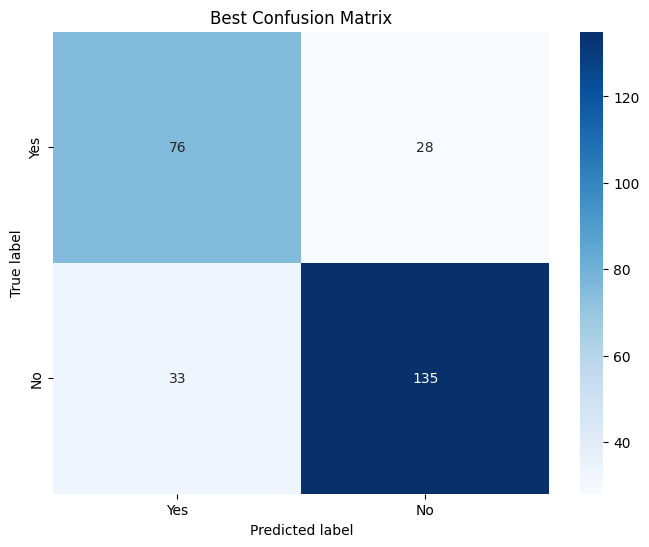

In [ ]:
plot_confusion_matrix(cm,class_names,'Best')
bestVisualization.show()

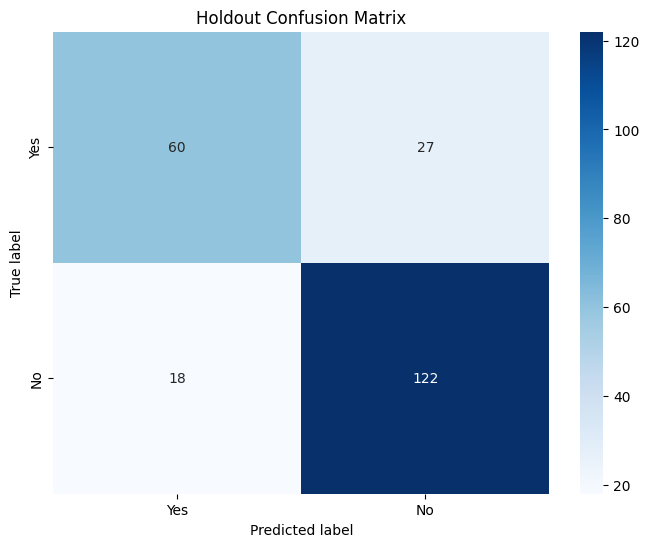

In [ ]:
plot_confusion_matrix(cm2,class_names,'Holdout')
holdout_visualization.show()

## KNN

### Grid search

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3)

# Create the base KNN classifier
base_classifier = KNeighborsClassifier()

# Define the hyperparameters and their possible values for the grid search
param_grid = {
    'n_neighbors': [5,7,9,11],
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski','euclidean','manhattan']
}

# Create the GridSearchCV object
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=50)
grid_search = GridSearchCV(estimator=base_classifier, param_grid=param_grid, cv=cv, scoring='balanced_accuracy', n_jobs=-1)

# Fit the GridSearchCV object on the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding balanced accuracy score
print("Best parameters: ", grid_search.best_params_)
print("Best balanced accuracy: ", grid_search.best_score_)

# Retrieve the best model
best_classifier = grid_search.best_estimator_


Best parameters:  {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
Best balanced accuracy:  0.4521607782898105


### Model

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd


#average_metrics, (average_accuracy, average_precision, average_recall, average_f1, average_auc_roc, average_specificity, average_balance), (best_accuracy, best_precision, best_recall, best_f1, best_auc_roc, best_specificity, best_balance), best_model, y_test_binarized_best, y_score_best = compute_average_metrics_KNN(knn_classifier, X_encoded, y, n_iterations=1, displayOutput=False)

knn_classifier = KNeighborsClassifier(n_neighbors=5,metric='manhattan',weights='distance')
cm,avgScores, best_scores ,best_model, y_test_binarized_best, y_score_best = compute_average_metrics_KNN(knn_classifier, X_encoded, y, n_iterations=100, displayOutput=False)

Scores = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 score', 'AUC-ROC', 'Specificity', 'Balanced Accuracy'],
    'Average': [average_accuracy, average_precision, average_recall, average_f1, average_auc_roc, average_specificity, average_balance],
    'Best': [best_accuracy, best_precision, best_recall, best_f1, best_auc_roc, best_specificity, best_balance],
}

# Create a DataFrame and display the table
bestVisualization = displayAUC(y_test_binarized_best,y_score_best,class_names,title = 'Best model')


Iteration 1: Skipped due to only one class present in y_true.
Iteration 1: Skipped due to only one class present in y_true.
Iteration 1: Skipped due to only one class present in y_true.
Iteration 1: Skipped due to only one class present in y_true.
Iteration 1: Skipped due to only one class present in y_true.
Iteration 2: Skipped due to only one class present in y_true.
Iteration 2: Skipped due to only one class present in y_true.
Iteration 2: Skipped due to only one class present in y_true.
Iteration 2: Skipped due to only one class present in y_true.
Iteration 2: Skipped due to only one class present in y_true.
Iteration 3: Skipped due to only one class present in y_true.
Iteration 3: Skipped due to only one class present in y_true.
Iteration 3: Skipped due to only one class present in y_true.
Iteration 3: Skipped due to only one class present in y_true.
Iteration 3: Skipped due to only one class present in y_true.
Iteration 4: Skipped due to only one class present in y_true.
Iteratio

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:189: RuntimeWarning:

invalid value encountered in double_scalars



UnboundLocalError: ignored

### Holdout

In [ ]:
holdout_test = holdout[target]
holdout1 = holdout.drop(target, axis=1)
holdout1 = holdout1[selected_cols]
holdout1 = encoder.fit_transform(holdout1)

y_pred = best_model.predict(holdout1)
y_score = best_model.predict_proba(holdout1)
y_test_binarized = label_binarize(holdout_test, classes=np.unique(y))
accuracy = accuracy_score(holdout_test, y_pred)
precision = precision_score(holdout_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(holdout_test, y_pred, average='weighted',zero_division=0)
f1 = f1_score(holdout_test, y_pred, average='weighted')        
specificity = specificity_score(holdout_test,y_pred,average='weighted')
balanced_accuracy = (recall + specificity) / 2
auc_roc = roc_auc_score(y_test_binarized, y_score, multi_class='ovr', average='weighted')
Scores['Holdout'] = [accuracy, precision, recall, f1, auc_roc, specificity, balanced_accuracy]

class_names  = ['No risk','Low risk', 'Low-medium risk', 'Medium risk', 'Medium-high risk','High risk']
holdout_visualization = displayAUC(y_test_binarized,y_score,class_names,title = 'Holdout')

cm2 = confusion_matrix(holdout_test, y_pred)

### Scores

In [ ]:
scoresDF = pd.DataFrame(Scores)
scoresDF.set_index('Metric', inplace=True)
scoresDF['Difference'] = scoresDF['Best'] - scoresDF['Holdout']
scoresDF['Sign'] = scoresDF['Difference'].apply(lambda x: '+' if x >= 0 else '-')
display(scoresDF)

,Average,Best,Holdout,Difference,Sign
Metric,,,,,
Accuracy,0.559728,0.632353,0.506608,0.125745,+
Precision,0.549776,0.619167,0.511562,0.107605,+
Recall,0.559728,0.632353,0.506608,0.125745,+
F1 score,0.550760,0.623572,0.507157,0.116415,+
AUC-ROC,0.844049,0.864517,0.778006,0.086512,+
Specificity,0.866988,0.891324,0.855810,0.035514,+
Balanced Accuracy,0.713358,0.761839,0.681209,0.080630,+


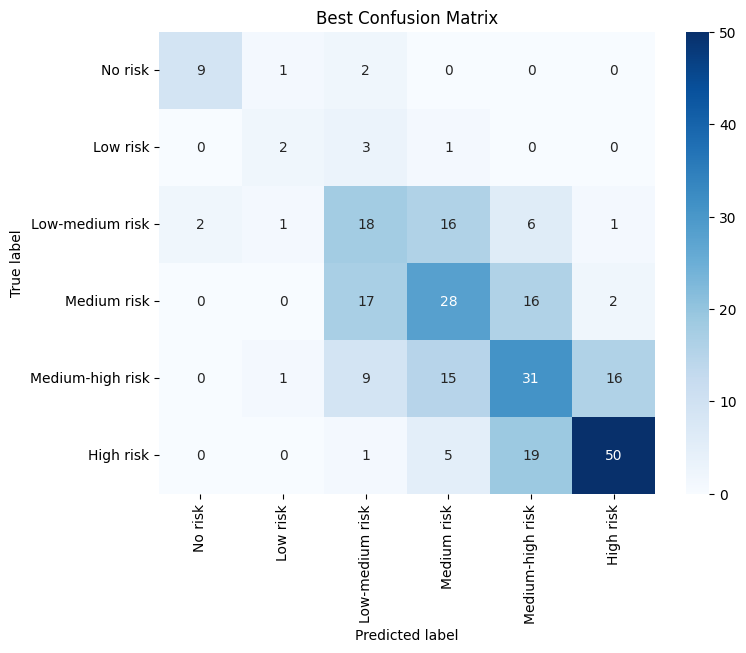

In [ ]:
plot_confusion_matrix(cm,class_names,'Best')
bestVisualization.show()

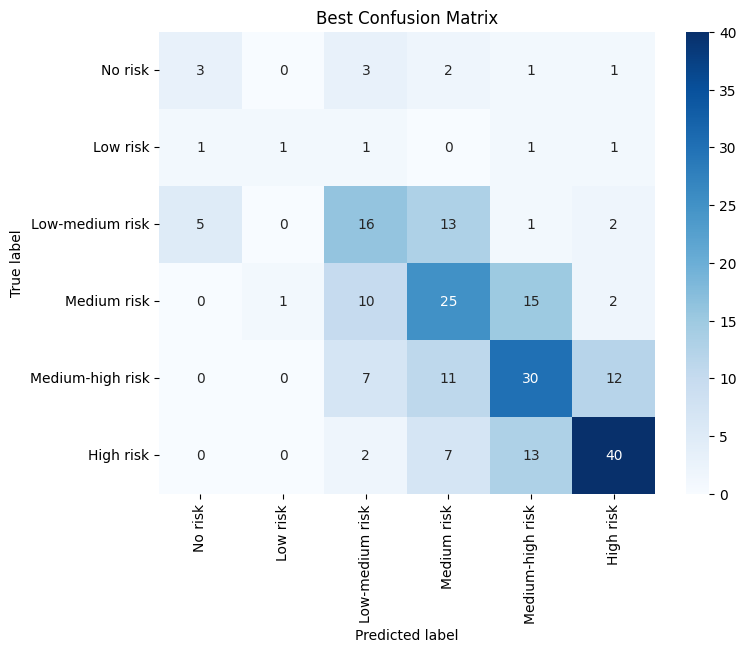

In [ ]:
plot_confusion_matrix(cm2,class_names,'Best')
holdout_visualization.show()

## CatBoost

In [ ]:
#!pip install catboost
from catboost import CatBoostClassifier

def compute_average_metrics_CatBoost(classifier, X, y, n_iterations=10, save_model=True, model_filename='CatBoost.pkl', displayOutput=True):
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    auc_roc_scores = []
    specificity_scores = []
    balanced_accuracy_scores = []
    best_auc_roc = -1
    best_model = None
    best_scores = None
    y_test_binarized_best = None
    y_score_best= None    
    best_balanced_accuracy = -1


    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3)

    for i in range(n_iterations):
      for train_index, test_index in cv.split(X_encoded, y):
            X_train, X_test = X_encoded[train_index], X_encoded[test_index]
            y_train, y_test = y[train_index], y[test_index]
        
              # Train a decision tree classifier
            #X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3)

            # Train a KNN classifier
            classifier.fit(X_train, y_train)

            # Test the classifier on the test set and store the metrics
            y_pred = classifier.predict(X_test)
            y_score = classifier.predict_proba(X_test)
            y_test_binarized = label_binarize(y_test, classes=np.unique(y))
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
            recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
            f1 = f1_score(y_test, y_pred, average='weighted')
            specificity = specificity_score(y_test,y_pred,average='weighted')
            balanced_accuracy = (recall + specificity) / 2

            try:
                auc_roc = roc_auc_score(y_test_binarized, y_score, multi_class='ovr', average='weighted')
            except ValueError:
                print(f"Iteration {i + 1}: Skipped due to only one class present in y_true.")
                continue

            if balanced_accuracy > best_balanced_accuracy:
              best_balanced_accuracy = balanced_accuracy
              best_auc_roc = auc_roc
              best_model = classifier
              best_scores = (accuracy, precision, recall, f1, auc_roc,specificity,balanced_accuracy)
              y_test_binarized_best = y_test_binarized
              y_score_best= y_score

            accuracy_scores.append(accuracy)
            precision_scores.append(precision)
            recall_scores.append(recall)
            f1_scores.append(f1)
            auc_roc_scores.append(auc_roc)
            specificity_scores.append(specificity)
            balanced_accuracy_scores.append(balanced_accuracy)

            cm = confusion_matrix(y_test, y_pred)


            if displayOutput == True:
                print(f"Iteration {i + 1}:")
                print(f"  Accuracy: {accuracy:.2f}")
                print(f"  Precision: {precision:.2f}")
                print(f"  Recall: {recall:.2f}")
                print(f"  F1 score: {f1:.2f}")
                print(f"  AUC-ROC score: {auc_roc:.2f}")
                print(f"  Specificity score: {specificity:.2f}")
                print(f"  Balanced Accuracy Score: {balanced_accuracy:.2f}")

    with open(model_filename, 'wb') as f:
      pickle.dump(best_model, f)
    average_accuracy = np.mean(accuracy_scores)
    average_precision = np.mean(precision_scores)
    average_recall = np.mean(recall_scores)
    average_f1 = np.mean(f1_scores)
    average_auc_roc = np.mean(auc_roc_scores)
    average_specificity = np.mean(specificity_scores)
    average_balance = np.mean(balanced_accuracy_scores)

    avgScores = (average_accuracy, average_precision, average_recall, average_f1, average_auc_roc, average_specificity, average_balance)

    return cm,avgScores, best_scores, best_model, y_test_binarized_best, y_score_best


# Then create the CatBoost classifier and call the compute_average_metrics_CatBoost function:

catboost_classifier = CatBoostClassifier(iterations=500, learning_rate=0.1, depth=6, loss_function='MultiClass', verbose=False)
cm, avgScores, best_scores, best_model, y_test_binarized_best, y_score_best = compute_average_metrics_CatBoost(catboost_classifier, X_encoded, y, n_iterations=100, displayOutput=False)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 11.8 MB/s eta 0:00:00


In [ ]:
Scores = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 score', 'AUC-ROC', 'Specificity', 'Balanced Accuracy'],
    'Average': [average_accuracy, average_precision, average_recall, average_f1, average_auc_roc, average_specificity, average_balance],
    'Best': [best_accuracy, best_precision, best_recall, best_f1, best_auc_roc, best_specificity, best_balance],
}

# Create a DataFrame and display the table
bestVisualization = displayAUC(y_test_binarized_best,y_score_best,class_names,title = 'Best model')

In [ ]:
holdout_test = holdout[target]
holdout1 = holdout.drop(target, axis=1)
holdout1 = holdout1[selected_cols]
holdout1 = encoder.fit_transform(holdout1)

y_pred = best_model.predict(holdout1)
y_score = best_model.predict_proba(holdout1)
y_test_binarized = label_binarize(holdout_test, classes=np.unique(y))
accuracy = accuracy_score(holdout_test, y_pred)
precision = precision_score(holdout_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(holdout_test, y_pred, average='weighted',zero_division=0)
f1 = f1_score(holdout_test, y_pred, average='weighted')        
specificity = specificity_score(holdout_test,y_pred,average='weighted')
balanced_accuracy = (recall + specificity) / 2
auc_roc = roc_auc_score(y_test_binarized, y_score, multi_class='ovr', average='weighted')
Scores['Holdout'] = [accuracy, precision, recall, f1, auc_roc, specificity, balanced_accuracy]

class_names  = ['No risk','Low risk', 'Low-medium risk', 'Medium risk', 'Medium-high risk','High risk']
holdout_visualization = displayAUC(y_test_binarized,y_score,class_names,title = 'Holdout')

cm2 = confusion_matrix(holdout_test, y_pred)

In [ ]:
scoresDF = pd.DataFrame(Scores)
scoresDF.set_index('Metric', inplace=True)
scoresDF['Difference'] = scoresDF['Best'] - scoresDF['Holdout']
scoresDF['Sign'] = scoresDF['Difference'].apply(lambda x: '+' if x >= 0 else '-')
display(scoresDF)

,Average,Best,Holdout,Difference,Sign
Metric,,,,,
Accuracy,0.559728,0.632353,0.555066,0.077287,+
Precision,0.549776,0.619167,0.558416,0.060751,+
Recall,0.559728,0.632353,0.555066,0.077287,+
F1 score,0.550760,0.623572,0.553443,0.070129,+
AUC-ROC,0.844049,0.864517,0.839929,0.024589,+
Specificity,0.866988,0.891324,0.869261,0.022064,+
Balanced Accuracy,0.713358,0.761839,0.712163,0.049675,+


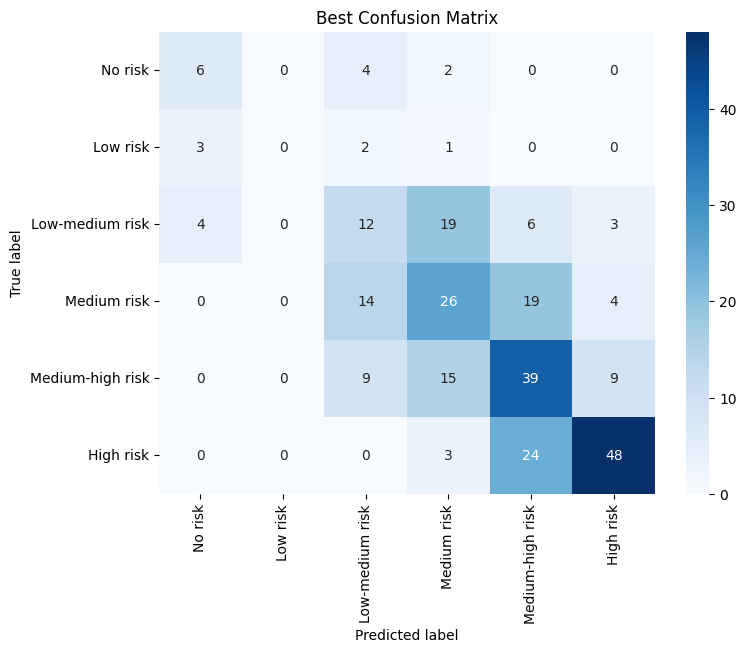

In [ ]:
plot_confusion_matrix(cm,class_names,'Best')
bestVisualization.show()

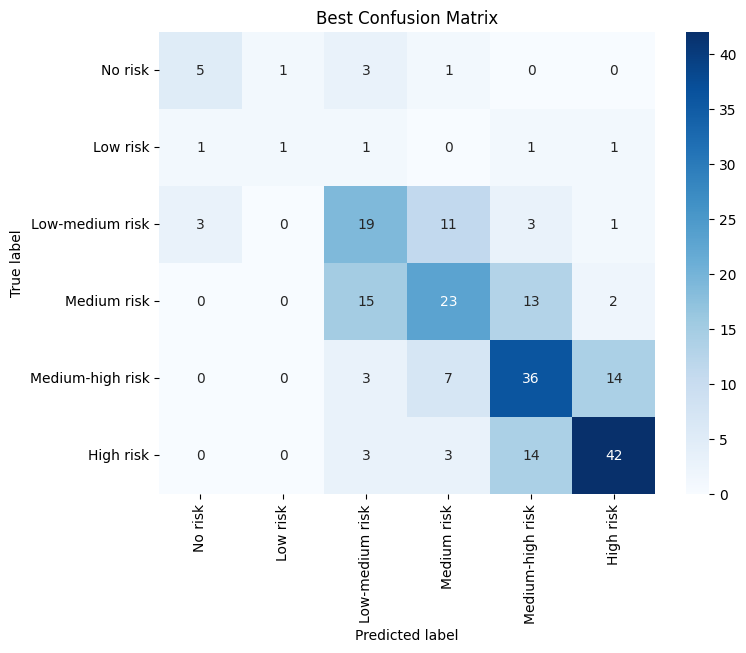

In [ ]:
plot_confusion_matrix(cm2,class_names,'Best')
holdout_visualization.show()